</p>Run simulation of filling in network corresponding to the Alameda neighborhood from Araijan, Panama</p>
<p>**Only have .inp and suggested .config file output from cleanupinpfiles.py**</p>
<p> Below you see how to:</p>
<ul>
<li>Rewrite new .config and .inp files using desired network and runtime parameters</li>
<li>Restart a simulation and save data (this is a big network with lots of pipes!); need to run it for awhile to see filling process propogate through</li>
<li>Plot elevation profile for network 'spine'</li>
</ul>

In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from writeit import *
import pickle
import time


Populating the interactive namespace from numpy and matplotlib


In [2]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [3]:
#first load information from the output of cleanupinpfiles.py to get network connectivity and geometry info
fi = "../indata/Alameda62.0.0.inp" 
fc = "../indata/Alameda62.0.config"
n0 = PyNetwork(fi,fc,1)

In [4]:
Ls = n0.Ls
T = 20  #set simulation time per run
Mi = 10   #number of time steps in between writes
Nt =1    #number of simulations to do
Ttot = Nt*T  # total simulation time
Np = n0.Nedges
a = 100    #pressure wave speed (this determines slot width)
Ns = [int(l) for l in Ls]   # set dx = 1 meter by assigning 1 grid cell per meter of length
Ds = n0.Ds
dx = [Ls[i]/Ns[i] for i in range(Np)]  
M = int(T*a/(max(dx)*.8))*4#set time steps based on dx to assure CFL condition
M = (M+Mi-M%Mi)  #round it up to be an even multiple of Mi
jt = n0.nodeTypes
Nn = len(jt)

#boundary types: need to specify three parameters for each junction1:
#--r: reflection (1 means reflect all waves, -1 means reflect none, 0 means apply one of the cases (0-2) in bt )
#--bt: boundary type (0 means specify A, 1 means specify Q, 2 means orifice outflow)
#--bv: boundary value (a float that specifies value, if constant) 
#      if nonconstant, subsequently use setBval(i,Y) for time series Y (length M+1)

#set boundary type (this will only matter for nodes where r =0)
bt = [2]*Nn     #all nodes orifice outflow
bt[0] = 1       #node 0 we'll specify inflow
if bt[0] ==0:
    sbtype = 'A'
elif bt[0]==1:
    sbtype ='Q'
#set boundary values to 0(this will only matter for nodes where r =0)
bv = [0]*Nn
#set reflection
r = [0]*Nn
r[0] = 0 # this node we'll specify inflow
r[17] =1  #these nodes will reflect everything
r[19]=1
r[20]=1

bt[0] =1  #set boundary type of node 0 to specify Q(t)
h0s = [0]*Np  #initialize .config file to (A,Q) =(0,0) in all pipes
q0s = [0]*Np
Mrs =[0.007]*Np  #Manning roughness coefficient =0.007 for all pipes


Nstar =1 #measuring point for each pipe
#elevation data for all nodes
elevs = [127.10, 126.19, 98.76, 91.44, 83.82, 78.029, 70.74, 61.26, 53.95, 57.9, 58.52, 60.05, 60.66, 62.79, 63.70, 73.15, 76.81, 76.2, 86.26, 84.43, 88.09, 96.32, 96.012, 99.67, 101.80, 103.63, 101.80, 101.19, 101.50, 103.95, 117.96, 129.84, 87.48, 97.23]

In [5]:
t0 = time.clock()
startfromsaved = 0  #set = 1 to start from saved data

#create matrices to store pressure and velocity data
# i^th row of Hs is the i^th timeslice, where we take Mi time steps of length dt in between storing each time slice
# the i^th time slice consists of the [H0[i], H1[i], ...H_Np[i]], 
# where H0[i] is the pressure data as a function of x in pipe 0 at time slice i, etc
# same indexing scheme holds for Us
Hs =np.zeros((M/Mi*Nt,sum(Ns)))
Us =np.zeros((M/Mi*Nt,sum(Ns)))#

#new prefix for .inp and .config files that will be used for actual runtime parameters
fn = "../indata/Alameda_m4"
#old .inp file with network connectivity
oldinp = "../indata/Alameda62.0.0.inp"
#write new files [fn].inp and [fn].config with new info 
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
#create the network you're actually going to run
n1 = PyNetwork(fi,fc,1)

dt = n1.T/float(n1.M)
#now set the initial conditions
if startfromsaved: #initialize with data from a previous simulation
    ICdata = pickle.load(open('summary_results_saved_at2015_11_15_16_40_13.pkl','rb'))
    Af = ICdata['Af']
    Qf = ICdata['Qf']

for i in range(0,Np):
    #print "Af = %f, A0= %f, H0/D = %f"%(Ai, A0[0], p0.HofA(A0[0],False)/Ds[i])
    if startfromsaved:
    #subsequent runs use old data
        A0 = Af[i]
        Q0 = Qf[i]
    else:
        Ai = ((Ds[i]**2)/4.)*np.pi
        #initial condition empty
        A0 = .01*Ai*ones(n1.Ns[i])
        p0 = PyPipe_ps(n1.Ns[i],n1.Ds[i], n1.Ls[i],M,a)
        Q0 = 0*np.ones(n1.Ns[i])
    n1.setIC(i,A0,Q0)
N = n1.Ns[0]
p0 = PyPipe_ps(N,n1.Ds[0], n1.Ls[0],M,a)
A00 = p0.AofH(20,False)
Q00 = 0.0087 
n1.setIC(0,A00*np.ones(n1.Ns[0]), Q00*np.ones(n1.Ns[0]))
Qb = Q00*np.ones(M+1)
aa=arange(0,len(n1.nodeTypes))
for j in range(len(aa[n1.nodeTypes==1])):#find the junction1s and set boundary value time series to .1*(pipe diameter)
    bvt = n1.Ds[0]*.1*np.ones(M+1)
    n1.setbVal(j,bvt)
    bv[j] =bvt[0]#record boundary value  
#specify an boundary inflow at node 0   
n1.setbVal(0,Qb)
print "size of matrix storing pressure head history is"
print shape(Hs)#watch out if this matrix is huge--make Mi bigger or Nt smaller so you don't have such large data sets.
print "simulation time between checkpoints is %f s"%(dt*Mi)
print "specifying %s = %f at node 0"%(sbtype, Qb[0])



size of matrix storing pressure head history is
(959, 2641)
simulation time between checkpoints is 0.020855 s
specifying Q = 0.008700 at node 0


In [6]:
#Show the initial conditions before you start the simulation
#n1.showCurrentData()

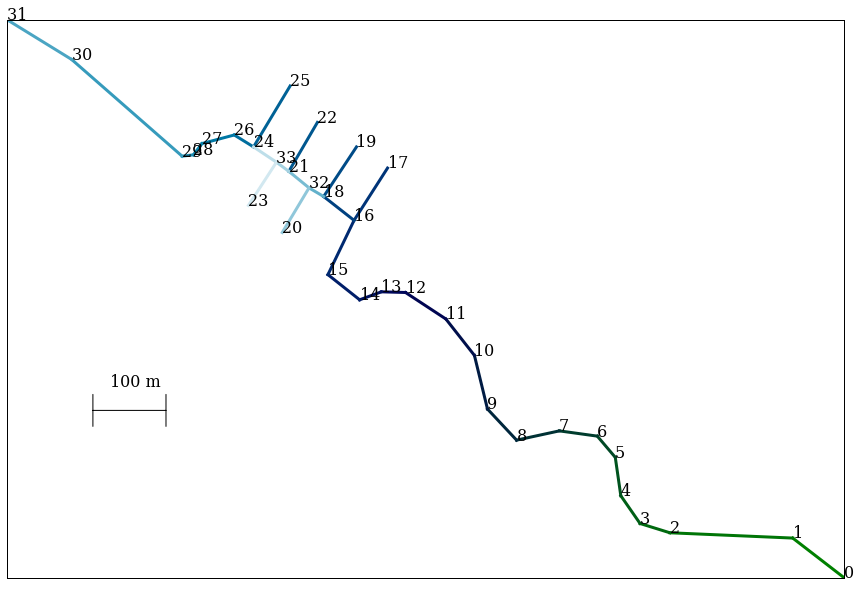

In [7]:
#draw a map of the network
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)

In [8]:
t0= time.clock() 
Vs = [n1.getTotalVolume()]  #store the system volume at times [0, T, 2*T, ...Nt*T]
for m in range(Nt):
    n1.runForwardProblem(dt)#run the forward problem
    print 'simulation time =%f s'%(T*(m+1))#show what time we're at
    Ntot = 0
    for j in range(Np):
        N = n1.Ns[j]
        qh = n1.qhist(j)
        for n in range(1,M+1,Mi):
            Px = n1.pressureSpaceSeries(j,n)
            Utemp = [qh[idx_t(1,k,n,N)]/qh[idx_t(0,k,n,N)] for k in range(1,N+1)]
            Hs[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Px
            Us[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Utemp
        Ntot+=N
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()  #reset internal counter to zero so network can be run again
elapsed_t = time.clock()-t0
print "Wall clock time = %f"%elapsed_t

simulation time =20.000000 s
0
[1.0730729623106725, 1.2473882501224813]
Wall clock time = 141.728380


a = 100.0 m/s
inflow volume = 329.53 gallons
system volume = 4090.593358
Elapsed time = 141.728380


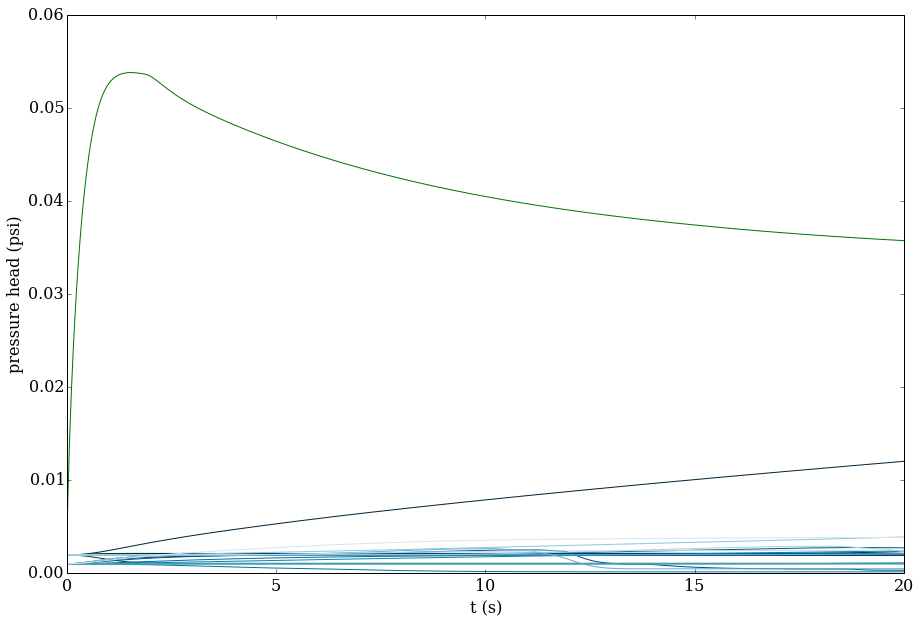

In [12]:
m2psi = 1.42 #conversion factor, meters to psi
m32gal=264.172052 #conversion factor m^3 to gallons
from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
fig,ax = plt.subplots(figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
t = linspace(0,Ttot,M/Mi*Nt)
Ntot = 0
interesting = arange(1,Np)
for k in interesting:
    plot(t,m2psi*Hs[:,sum(Ns[0:k])],label="%d"%k, color = scalarMap.to_rgba(k))
    #plot(t,m2psi*Hs2[k,:],'g',label="%d"%k)# color = scalarMap.to_rgba(k))
xlabel('t (s)')
ylabel('pressure head (psi)')


print "a = %.1f m/s" %a
Vsys = 0
for k in range(Np):
    Vsys +=Ls[k]*(Ds[k]**2)/4.*np.pi
print "inflow volume = %.2f gallons"%((Vs[-1])*m32gal)
print "system volume = %f"% (Vsys*m32gal)
print "Elapsed time = %f" %elapsed_t

In [11]:
#show max pressure in each pipe
print "pipe max(H)"
for k in range(Np):
    print "%d     %f"%(k,m2psi*max(Hs[-1,sum(Ns[0:k]):sum(Ns[0:k+1])]))

pipe max(H)
0     0.082207
1     0.035715
2     0.001921
3     0.001941
4     0.002107
5     0.003152
6     0.002282
7     0.009266
8     0.011986
9     0.002507
10     0.002469
11     0.003004
12     0.002757
13     0.002851
14     0.002924
15     0.002747
16     0.003464
17     0.003059
18     0.003120
19     0.004174
20     0.001943
21     0.002356
22     0.002579
23     0.002356
24     0.001423
25     0.001083
26     0.000960
27     0.000974
28     0.003044
29     0.005455
30     0.002259
31     0.002586
32     0.003807


In [78]:
#set up data to save to a file
Note = "initial condition is specify %s = 0 at node 0\
    base inp file is %s"%(sbtype,oldinp)


In [79]:
Af = []
Qf = []
for k in range(Np):
    q = n1.q(k)
    Af.append(np.array(q[0:Ns[k]]))
    Qf.append(np.array(q[ Ns[k]:]))

In [80]:
solve_t = elapsed_t
s = "%d_%d_%d_%d_%d_%d"%(tuple([t[i] for i in range(6)]))
f1=  open('results_%d_s_saved_at%s.pkl'%(int(Ttot),s),'wb')
data = {'Hs':Hs, 'Us':Us, 'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
         "reported time":rtime,
       'Af':Af,
       'Qf': Qf,
       'Vs':Vs}
pickle.dump(data,f1)
f1.close()

In [81]:
print f1

<closed file 'results_2_s_saved_at0_0_0_0_0_0.pkl', mode 'wb' at 0x10c3d4420>


In [82]:
#save smaller data set to a summeary file (without big Hs and Us matrices)
f2 = open('summary_results_saved_at%s.pkl'%s,'wb')

In [83]:
data = {'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
         "reported time":rtime, 
       'Af':Af,
       'Qf': Qf,
     'Vs':Vs}
pickle.dump(data,f2)
f2.close()